<a href="https://colab.research.google.com/github/HitenPatil27/Task-8-Clustering-with-K-Means/blob/main/Task_8_Clustering_with_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Load the dataset


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Step 2: Data Cleaning

In [6]:
df.dropna(inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df[df['Country'] == 'United Kingdom']

Step 3: Create RFM (Recency, Frequency, Monetary) features

In [8]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': lambda x: np.sum(df.loc[x.index, 'Quantity'] * df.loc[x.index, 'UnitPrice'])
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

Step 4: Normalize the data

In [9]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

Step 5: Elbow Method to find optimal k

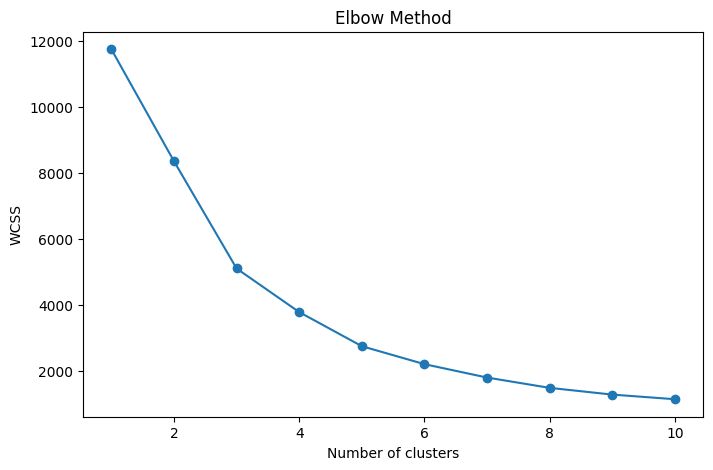

In [10]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Step 6: Apply KMeans with optimal K

In [11]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = clusters

Step 7: Silhouette Score

In [12]:
sil_score = silhouette_score(rfm_scaled, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.5951


Step 8: Visualize Clusters

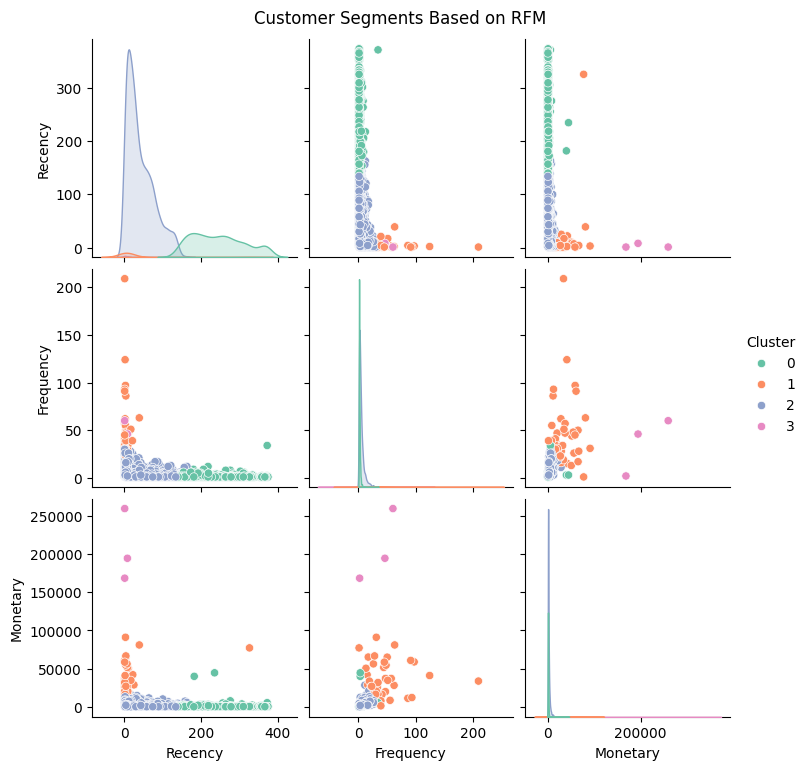

In [13]:
sns.pairplot(rfm.reset_index(), hue='Cluster', palette='Set2',
             vars=['Recency', 'Frequency', 'Monetary'])
plt.suptitle("Customer Segments Based on RFM", y=1.02)
plt.show()